In [1]:
import numpy
import scipy.special
import scipy.ndimage
import matplotlib.pyplot as plt
import csv
import cmath
import math
import time

In [76]:
class neuralNetwork_Real:
    
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        self.lr = learningrate
        
        self.inverse_activation_function = lambda x: 1/2 * numpy.log((x + 1) / (1 - x))
        self.activation_function = lambda x: (numpy.tanh(x))
        
        pass

    
    def train(self, inputs_list, targets_list):
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        hidden_inputs = numpy.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = numpy.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = numpy.dot(self.who.T, output_errors) 
        
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        
        pass

    def query(self, inputs_list):
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        hidden_inputs = numpy.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = numpy.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    def backquery(self, targets_list):
        final_outputs = numpy.array(targets_list, ndmin=2).T
        final_inputs = self.inverse_activation_function(final_outputs)

        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

In [121]:
class neuralNetwork:
    

    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):

        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.wih = numpy.array(self.wih, ndmin=2, dtype='complex128')
        self.wih += 1j * numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))

        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))
        self.who = numpy.array(self.who, ndmin=2, dtype='complex128')
        self.who += 1j * numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        self.lr = learningrate
        
        #self.activation_function = lambda x: 1 / (1 + numpy.exp(-x))
        self.inverse_activation_function = lambda x: 1/2 * numpy.log((x + 1) / (1 - x))
        #self.inverse_activation_function = lambda x: numpy.log(x / (1 - x))
        self.activation_function = lambda x: (numpy.tanh(x))
        #self.activation_function = lambda x: numpy.maximum(0.,x)

    def train(self, inputs_list, targets_list):
        inputs = numpy.array(inputs_list, dtype=complex, ndmin=2).T
        targets = numpy.array(targets_list, dtype=complex, ndmin=2).T

        hidden_inputs = numpy.dot(self.wih, inputs)
        hidden_act = self.activation_function(numpy.linalg.norm(hidden_inputs))
        hidden_outputs_real = hidden_act * numpy.cos(numpy.angle(hidden_inputs))
        hidden_outputs_imag = hidden_act * numpy.sin(numpy.angle(hidden_inputs))
        hidden_outputs = hidden_outputs_real + 1j * hidden_outputs_imag

        final_inputs = numpy.dot(self.who, hidden_outputs)
        final_outputs_real = self.activation_function(final_inputs.real)
        final_outputs_imag = self.activation_function((-1j * final_inputs.imag).real)
        final_outputs = final_outputs_real #+ 1j * final_outputs_imag

        output_errors = targets - final_outputs
        hidden_errors = numpy.dot(self.who.T, output_errors)

        self.who += self.lr * numpy.dot(output_errors * (1.0 - numpy.square(final_outputs)), numpy.conj(hidden_outputs).T)
        self.wih += self.lr * numpy.dot(hidden_errors * (1.0 - numpy.square(hidden_outputs)), numpy.conj(inputs).T)

    def query(self, inputs_list):
        inputs = numpy.array(inputs_list, dtype=complex, ndmin=2).T

        hidden_inputs = numpy.dot(self.wih, inputs)
        hidden_act = self.activation_function(numpy.linalg.norm(hidden_inputs))
        hidden_outputs_real = hidden_act * numpy.cos(numpy.angle(hidden_inputs))
        hidden_outputs_imag = hidden_act * numpy.sin(numpy.angle(hidden_inputs))
        hidden_outputs = hidden_outputs_real + 1j * hidden_outputs_imag

        final_inputs = numpy.dot(self.who, hidden_outputs)
        final_outputs_real = self.activation_function(final_inputs.real)
        final_outputs_imag = self.activation_function((-1j * final_inputs.imag).real)
        final_outputs = final_outputs_real #+ 1j * final_outputs_imag
        
        return final_outputs_real

In [132]:
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.001

In [123]:
training_data_file = open("mnist_dataset/mnist_train_100.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [124]:
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
n_r = neuralNetwork_Real(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [133]:
epochs = 20

print("Start Training..")

t_s = time.time()
for e in range(epochs):
    for record in training_data_list:
        all_values = record.split(',')
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        
    print("epochs:", e+1, "/", epochs)
t_f = time.time()

print("timecost = {0:0.2f} sec".format(t_f-t_s))

Start Training..
epochs: 1 / 20
epochs: 2 / 20
epochs: 3 / 20
epochs: 4 / 20
epochs: 5 / 20
epochs: 6 / 20
epochs: 7 / 20
epochs: 8 / 20
epochs: 9 / 20
epochs: 10 / 20
epochs: 11 / 20
epochs: 12 / 20
epochs: 13 / 20
epochs: 14 / 20
epochs: 15 / 20
epochs: 16 / 20
epochs: 17 / 20
epochs: 18 / 20
epochs: 19 / 20
epochs: 20 / 20
timecost = 2.18 sec


In [134]:
test_data_file = open("mnist_dataset/mnist_train_100.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

scorecard = []

for record in test_data_list:
    all_values = record.split(',')
    correct_label = int(all_values[0])
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    outputs = n.query(inputs)
    label = numpy.argmax(outputs)
    if label == correct_label:
        scorecard.append(1)
    else:
        scorecard.append(0)
    
scorecard_array = numpy.asarray(scorecard)
print("Performance =", scorecard_array.sum() / scorecard_array.size)

print(n.wih[0, 0:10])
print(test_data_complex)

Performance = 0.62
[-0.02556779-0.03774909j  0.04039655+0.0170454j   0.08281548-0.01054567j
  0.03830897-0.05072812j -0.02911512-0.02098357j -0.03667053+0.03189494j
  0.02868715+0.01004639j -0.03526234-0.04968067j -0.02879075+0.00907555j
  0.05929002-0.01841364j]
<function test_data_complex at 0x7f80078e6790>


In [126]:
def test_data_complex():
    scorecard = []
    for record in test_data_list:
        all_values = record.split(',')
        correct_label = int(all_values[0])
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        outputs = n.query(inputs)
        label = numpy.argmax(outputs)
        if label == correct_label:
            scorecard.append(1)
        else:
            scorecard.append(0)

    scorecard_array = numpy.asarray(scorecard)
    return scorecard_array.sum() / scorecard_array.size

In [127]:
def test_data_real():
    scorecard = []
    for record in test_data_list:
        all_values = record.split(',')
        correct_label = int(all_values[0])
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        outputs = n_r.query(inputs)
        label = numpy.argmax(outputs)
        if label == correct_label:
            scorecard.append(1)
        else:
            scorecard.append(0)

    scorecard_array = numpy.asarray(scorecard)
    return scorecard_array.sum() / scorecard_array.size

In [136]:
def get_complex_performance(trial):
    
    time_cost = 0
    list_avg = np.zeros(epochs)
    training_data_file = open("mnist_dataset/mnist_train_100.csv", 'r')
    training_data_list = training_data_file.readlines()
    training_data_file.close()
    
    for i in range(trial):
        
        n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
        temp = np.array([])
        t_s = time.time()
        for e in range(epochs):
            temp = np.append(temp, test_data_complex())
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                targets = numpy.zeros(output_nodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n.train(inputs, targets)
        print(temp)
        
        t_f = time.time()
        
        time_cost += t_f - t_s
        
        list_avg += temp
        
    time_cost /= trial
    list_avg /= trial
    
    return list_avg, time_cost

In [137]:
def get_real_performance(trial):
    
    time_cost = 0
    list_avg = np.zeros(epochs)
    
    for i in range(trial):
        n_r = neuralNetwork_Real(input_nodes, hidden_nodes, output_nodes, learning_rate)
        temp = np.array([])
        t_s = time.time()
        for e in range(epochs):
            temp = np.append(temp, test_data_real())
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                targets = numpy.zeros(output_nodes) + 0.01
                targets[int(all_values[0])] = 0.99
                n_r.train(inputs, targets)

        t_f = time.time()
        
        time_cost += t_f - t_s
        
        list_avg += temp
        
    time_cost /= trial
    list_avg /= trial
    
    return list_avg, time_cost

In [138]:
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
test_data_complex()

0.16

In [139]:
complex_recog_avg, complex_time_cost = get_complex_performance(1)

[0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16 0.16
 0.16 0.16 0.16 0.16 0.16 0.16]


In [54]:
real_recog_avg, real_time_cost = get_real_performance(10)

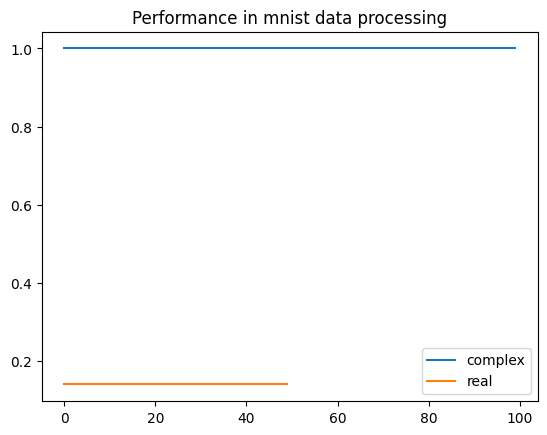

complex timecost = 11.01 sec
real timecost = 2.57 sec


In [101]:
plt.title("Performance in mnist data processing")
plt.plot(complex_recog_avg, label = 'complex')
plt.plot(real_recog_avg, label = 'real')
plt.legend()
plt.show()
print("complex timecost = {0:0.2f} sec".format(complex_time_cost))
print("real timecost = {0:0.2f} sec".format(real_time_cost))

In [99]:
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
temp = np.array([])

epochs = 100

t_s = time.time()
for e in range(epochs):
    temp = np.append(temp, test_data_complex())
    for record in training_data_list:
        all_values = record.split(',')
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
    t_f = time.time()
print(temp)


[0.1  0.09 0.1  0.14 0.12 0.15 0.15 0.17 0.19 0.21 0.25 0.28 0.28 0.34
 0.36 0.38 0.44 0.46 0.47 0.5  0.54 0.57 0.58 0.62 0.64 0.65 0.67 0.71
 0.72 0.73 0.73 0.75 0.77 0.79 0.8  0.8  0.82 0.83 0.84 0.84 0.84 0.85
 0.85 0.88 0.91 0.92 0.93 0.93 0.93 0.94 0.94 0.94 0.94 0.94 0.95 0.97
 0.97 0.97 0.97 0.97 0.97 0.97 0.98 0.98 0.98 0.98 0.98 0.98 0.98 0.98
 0.98 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.  ]


In [15]:
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

epochs = 100
trial = 50
print("Start Training..")

t_s = time.time()
for e in range(epochs):
    for record in training_data_list:
        all_values = record.split(',')
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
t_f = time.time()

print("timecost = {0:0.2f} sec".format(t_f-t_s))

Start Training..
epochs: 1 / 100
epochs: 2 / 100
epochs: 3 / 100
epochs: 4 / 100
epochs: 5 / 100
epochs: 6 / 100
epochs: 7 / 100
epochs: 8 / 100
epochs: 9 / 100
epochs: 10 / 100
epochs: 11 / 100
epochs: 12 / 100
epochs: 13 / 100
epochs: 14 / 100
epochs: 15 / 100
epochs: 16 / 100
epochs: 17 / 100
epochs: 18 / 100
epochs: 19 / 100
epochs: 20 / 100
epochs: 21 / 100
epochs: 22 / 100
epochs: 23 / 100
epochs: 24 / 100
epochs: 25 / 100
epochs: 26 / 100
epochs: 27 / 100
epochs: 28 / 100
epochs: 29 / 100
epochs: 30 / 100
epochs: 31 / 100
epochs: 32 / 100
epochs: 33 / 100
epochs: 34 / 100
epochs: 35 / 100
epochs: 36 / 100
epochs: 37 / 100
epochs: 38 / 100
epochs: 39 / 100
epochs: 40 / 100
epochs: 41 / 100
epochs: 42 / 100
epochs: 43 / 100
epochs: 44 / 100
epochs: 45 / 100
epochs: 46 / 100
epochs: 47 / 100
epochs: 48 / 100
epochs: 49 / 100
epochs: 50 / 100
epochs: 51 / 100
epochs: 52 / 100
epochs: 53 / 100
epochs: 54 / 100
epochs: 55 / 100
epochs: 56 / 100
epochs: 57 / 100
epochs: 58 / 100
epochs

In [ ]:
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
n_r = neuralNetwork_Real(input_nodes, hidden_nodes, output_nodes, learning_rate)

epochs = 500
trial = 10
print("Start Training..")

t_s = time.time()
for e in range(epochs):
    for record in training_data_list:
        all_values = record.split(',')
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        n.train(inputs, targets)
        
    print("epochs:", e+1, "/", epochs)
t_f = time.time()

print("timecost = {0:0.2f} sec".format(t_f-t_s))

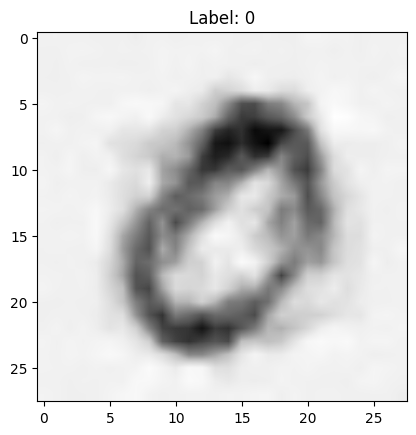

[[0.98208996]
 [0.65508412]
 [0.45720856]
 [0.48380113]
 [0.47679257]
 [0.57001093]
 [0.47822345]
 [0.55333216]
 [0.56827304]
 [0.58105632]]


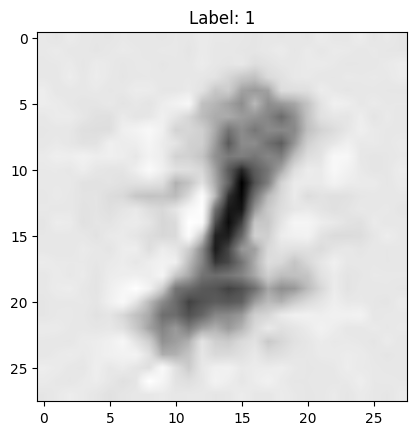

[[0.4845457 ]
 [0.97882486]
 [0.54733783]
 [0.46876564]
 [0.46203447]
 [0.47785107]
 [0.435855  ]
 [0.45535772]
 [0.60821776]
 [0.57073437]]


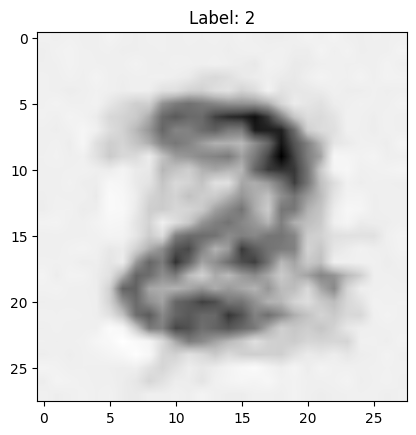

[[0.53455152]
 [0.5682236 ]
 [0.95935871]
 [0.47669773]
 [0.49828924]
 [0.49694905]
 [0.44285929]
 [0.52809862]
 [0.58438762]
 [0.60675329]]


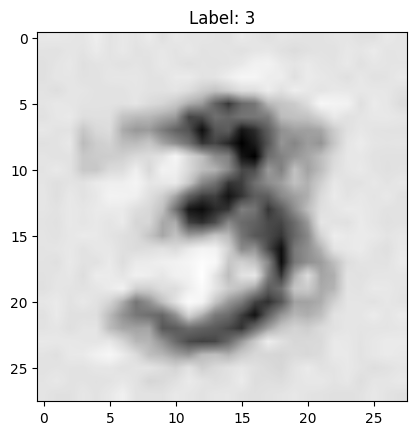

[[0.59376146]
 [0.57781442]
 [0.4784485 ]
 [0.96152043]
 [0.45093359]
 [0.502947  ]
 [0.52135953]
 [0.41734179]
 [0.56782589]
 [0.65308512]]


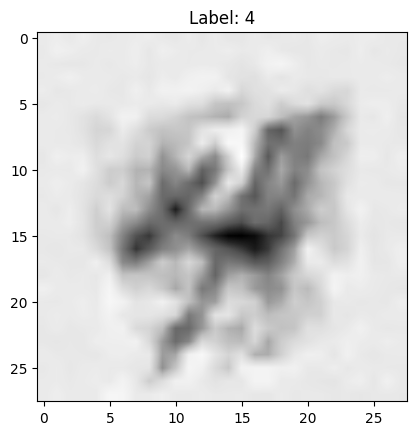

[[0.49696524]
 [0.65322043]
 [0.51045629]
 [0.42346481]
 [0.98364526]
 [0.49983698]
 [0.38804966]
 [0.46648298]
 [0.51373473]
 [0.56894909]]


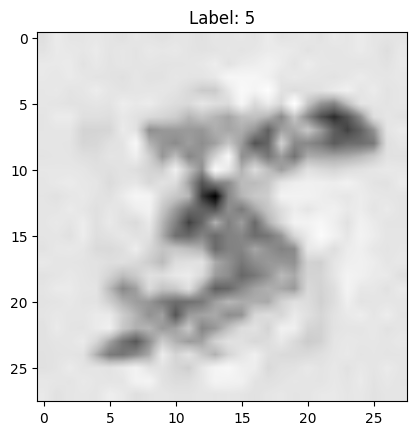

[[0.49726794]
 [0.16817736]
 [0.70046227]
 [0.5120583 ]
 [0.82079418]
 [0.91689118]
 [0.32043375]
 [0.48104985]
 [0.52251296]
 [0.41745252]]


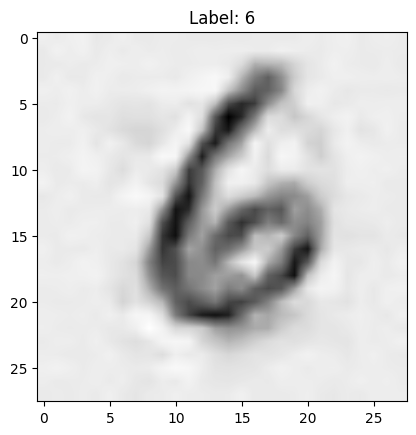

[[0.48472071]
 [0.51921756]
 [0.51010616]
 [0.49361487]
 [0.42091477]
 [0.52036487]
 [0.9821241 ]
 [0.48135423]
 [0.46948726]
 [0.68146947]]


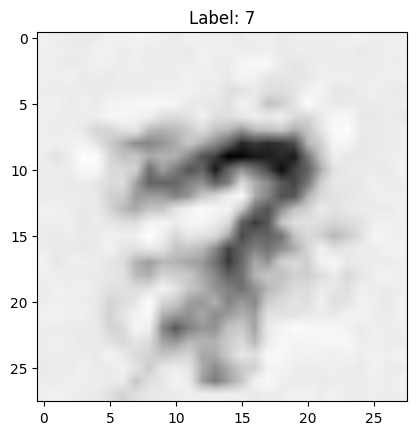

[[0.49020274]
 [0.46176265]
 [0.57999625]
 [0.4200321 ]
 [0.5079857 ]
 [0.4447421 ]
 [0.51462655]
 [0.97285276]
 [0.54311693]
 [0.51052151]]


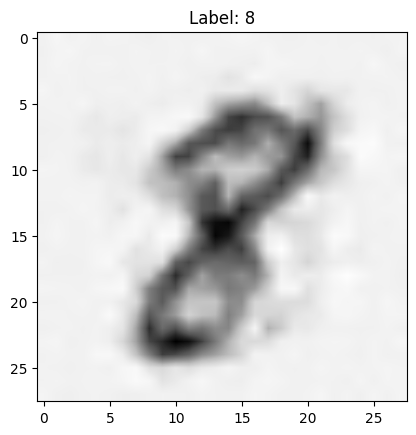

[[0.67920391]
 [0.54886692]
 [0.50094942]
 [0.43916438]
 [0.66901419]
 [0.32488026]
 [0.41067546]
 [0.36510305]
 [0.91874437]
 [0.63170222]]


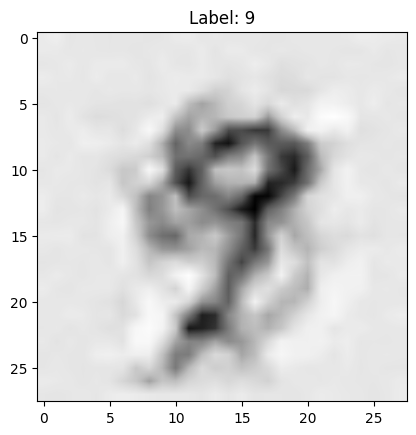

[[0.52944424]
 [0.63274659]
 [0.56038742]
 [0.44870331]
 [0.34049971]
 [0.61751819]
 [0.52240101]
 [0.42334277]
 [0.57814902]
 [0.99432021]]


In [9]:
import numpy as np

for label in range(10):
    targets = np.zeros(output_nodes) + 0.01
    targets[label] = 0.99
    final_outputs = np.array(targets, ndmin=2).T
    final_inputs = n.inverse_activation_function(final_outputs)

    hidden_outputs = np.matmul(np.linalg.pinv(n.who), targets)
    
    hidden_outputs_norm = np.abs(hidden_outputs)
    hidden_outputs_arg = np.angle(hidden_outputs)
    hidden_outputs_norm -= np.min(hidden_outputs_norm) - 0.001

    hidden_outputs = hidden_outputs_norm * np.cos(hidden_outputs_arg) + 1j * hidden_outputs_norm * np.sin(hidden_outputs_arg)

    hidden_outputs_norm /= np.max(hidden_outputs_norm)
    hidden_outputs_norm *= 0.98
    hidden_outputs_norm += 0.01
    hidden_inputs_norm = n.inverse_activation_function(hidden_outputs_norm)
    hidden_inputs = hidden_inputs_norm * np.cos(hidden_outputs_arg) + 1j * hidden_inputs_norm * np.sin(hidden_outputs_arg)

    inputs = np.dot(n.wih.T, hidden_inputs)
    inputs_norm = np.abs(inputs)
    inputs_angle = np.angle(inputs)
    inputs_norm -= np.min(inputs_norm) + 0.001
    inputs_norm /= np.max(inputs_norm)
    inputs_norm *= 0.98
    inputs_norm += 0.01
    inputs = inputs_norm * (np.cos(inputs_angle) + 1j * np.sin(inputs_angle))

    
    # Display the reconstructed input as an image
    plt.imshow(inputs.real.reshape(28, 28), cmap='Greys', interpolation='bilinear')
    plt.title(f"Label: {label}")
    plt.show()

    print(n.query(inputs.T))